In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow.utilities import print_summary, positive, set_trainable
from gpflow.config import set_default_float, default_float, set_default_summary_fmt
from gpflow.ci_utils import ci_niter
from gpflow.optimizers import NaturalGradient
set_default_float(np.float64)
set_default_summary_fmt("notebook")

plt.style.use("ggplot")
%matplotlib inline
# np.random.seed(1366)
tf.config.run_functions_eagerly(True)

In [2]:
data_pd = 'metric_euc.txt'
def _octonion_dist(X, X2):
    X = tf.reshape(X, [-1,1])
    pd = np.loadtxt(data_pd)
    X2 = tf.reshape(X2, [-1,1])
    dist0 = np.zeros((len(X), len(X2)))
    dist = tf.Variable(dist0) # Use variable 
    for i in range(len(X)):
        init_val = int(X[i].numpy())
        for j in range(len(X2)):
            fin_val = int(X2[j].numpy())
            dist0[i,j] = pd[init_val, fin_val]
    dist.assign(dist0)
    return dist

def _octonion_dist_single(X):
    X = tf.reshape(X, [-1,1])
    pd = np.loadtxt(data_pd)
    dist0 = np.zeros((len(X)))
    dist = tf.Variable(dist0) # Use variable 
    for i in range(len(X)):
        init_val = int(X[i].numpy())

        dist0[i] = pd[init_val, init_val]
    dist.assign(dist0)
    return dist

class GBKernel(gpflow.kernels.Kernel):
    def __init__(self, variance=1, lengthscales=.1, **kwargs):
        super().__init__(**kwargs)
        self.variance = gpflow.Parameter(variance, transform=positive())
        self.lengthscales = gpflow.Parameter(lengthscales, transform=positive())
        self._validate_ard_active_dims(self.lengthscales)
    
    def K(self, X, X2=None):
        X = X[:,0]
        if X2 is None:
            X2 = X
        else:
            X2 = X2[:,0]
        a = self.variance * tf.exp(-_octonion_dist(X, X2)/self.lengthscales)
        tf.debugging.check_numerics(self.lengthscales, 'hi')
        return a

    def K_diag(self, X):
        X = X[:,0]
        a = self.variance * tf.exp(-_octonion_dist_single(X)/self.lengthscales)
        tf.debugging.check_numerics(self.lengthscales, 'hi')
        return a

In [3]:
data0 = "../../data/first_cusp.txt"
data = np.loadtxt(data0)
X = data[:, 1:3]
Y = data[:, 3]


Y = (Y - np.mean(Y)) / np.std(Y)
ang = data[:,0].astype(int)


X = X.reshape(-1,2)
Y_all = Y.reshape(-1,1)
NoiseVar =np.exp(-((Y_all - 2) ** 2) / 4)/20
NoiseVar = NoiseVar.reshape(-1,1)

N = X.shape[0]
n_train =20

# I chose n_train gbs as training data set randomly
# id_train0 = np.sort(np.random.choice(N, size=n_train, replace=False))
id_train0 = np.floor(np.linspace(0,67,n_train))
id_train1 = np.array([0, 29,43,  67])
id_train0 = np.concatenate((id_train0, id_train1),axis=0)
id_train0 = np.unique(id_train0).astype(int)
id_train = np.hstack([id_train0.reshape(-1,1), X[id_train0][:,1].reshape(-1, 1)])
Y_train = Y_all[id_train[:,0].astype(int)].reshape(-1,1)
Nois_train = NoiseVar[id_train[:,0].astype(int)].reshape(-1,1)

# # # I chose rest of the gbs as the test set
id_test0 = X[~np.in1d(X[:,0], id_train0)][:,0]
id_test = np.hstack([id_test0.reshape(-1,1), X[id_test0.astype(int)][:,1].reshape(-1, 1)])
Y_test = Y_all[id_test0.astype(int)].reshape(-1,1)
Nois_test = NoiseVar[id_test[:,0].astype(int)].reshape(-1,1)

In [4]:

Y_data = np.hstack([Y_train, Nois_train])

Y_data_test = np.hstack([Y_test, Nois_test])

In [5]:
NoiseVar.shape

(68, 1)

In [6]:
class HeteroskedasticGaussian(gpflow.likelihoods.Likelihood):
    def __init__(self, **kwargs):
        # this likelihood expects a single latent function F, and two columns in the data matrix Y:
        super().__init__(latent_dim=1, observation_dim=2, **kwargs)

    def _log_prob(self, F, Y):
        # log_prob is used by the quadrature fallback of variational_expectations and predict_log_density.
        # Because variational_expectations is implemented analytically below, this is not actually needed,
        # but is included for pedagogical purposes.
        # Note that currently relying on the quadrature would fail due to https://github.com/GPflow/GPflow/issues/966
        Y, NoiseVar = Y[:, 0], Y[:, 1]
        return gpflow.logdensities.gaussian(Y, F, NoiseVar)

    def _variational_expectations(self, Fmu, Fvar, Y):
        Y, NoiseVar = Y[:, 0], Y[:, 1]
        Fmu, Fvar = Fmu[:, 0], Fvar[:, 0]
        return (
            -0.5 * np.log(2 * np.pi)
            - 0.5 * tf.math.log(NoiseVar)
            - 0.5 * (tf.math.square(Y - Fmu) + Fvar) / NoiseVar
        )

    # The following two methods are abstract in the base class.
    # They need to be implemented even if not used.

    def _predict_log_density(self, Fmu, Fvar, Y):
        raise NotImplementedError

    def _predict_mean_and_var(self, Fmu, Fvar):
        raise NotImplementedError


In [7]:
# model construction
likelihood = HeteroskedasticGaussian()
kernel = GBKernel()
model = gpflow.models.VGP((id_train, Y_data), kernel=kernel, likelihood=likelihood, num_latent_gps=1)

In [8]:
natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam()

set_trainable(model.q_mu, False)
set_trainable(model.q_sqrt, False)

for _ in range(ci_niter(1000)):
    natgrad.minimize(model.training_loss, [(model.q_mu, model.q_sqrt)])
    adam.minimize(model.training_loss, model.trainable_variables)


In [9]:

mean, var = model.predict_f(id_test)
mean_t, var_t = model.predict_f(id_train)

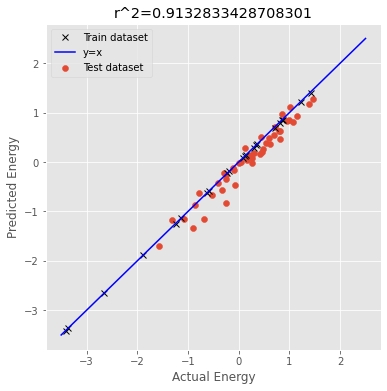

In [10]:
x = np.linspace(-3.5, 2.5,100)
plt.figure(figsize=(6, 6))

plt.scatter(Y_all[id_test[:,0].astype(int)], mean,label="Test dataset")
plt.plot(Y_all[id_train[:,0].astype(int)], mean_t, 'kx', label="Train dataset")
plt.plot(x, x,'b', label='y=x')
plt.legend()
plt.xlabel('Actual Energy')
plt.ylabel('Predicted Energy')
from sklearn.metrics import r2_score
r2 = r2_score(Y_all[id_test[:,0].astype(int)], mean)
plt.title('r^2='+str(r2))
plt.savefig('AP_withopt.jpg')

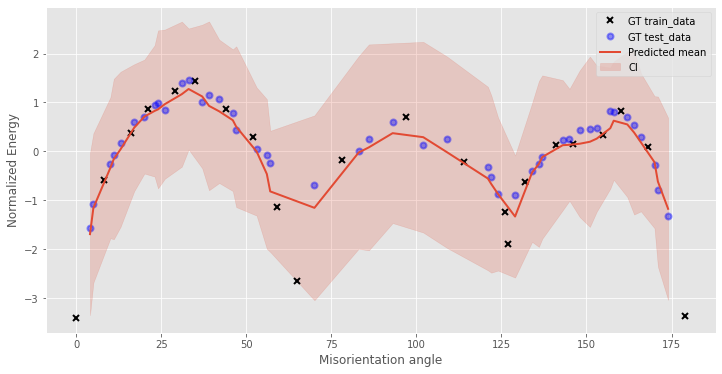

In [11]:


## generate 10 samples from posterior
tf.random.set_seed(10)  # for reproducibility


## plot
plt.figure(figsize=(12, 6))
plt.plot(ang[id_train[:,0].astype(int)].reshape(-1), Y_all[id_train[:,0].astype(int)], "kx", mew=2, label="GT train_data")
plt.plot(ang[id_test[:,0].astype(int)].reshape(-1), Y_all[id_test[:,0].astype(int)], "bo", mew=2, alpha=.4, label="GT test_data")
plt.plot(ang[id_test[:,0].astype(int)].reshape(-1), mean.numpy(), lw=2, label="Predicted mean")
plt.fill_between(
    ang[id_test[:,0].astype(int)],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2, label="CI"
)
plt.legend()
plt.xlabel('Misorientation angle')
plt.ylabel('Normalized Energy')
# plt.plot(xx, samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
# _ = plt.xlim(-0.1, 1.1)
plt.savefig('opt_CI.jpg')


<ErrorbarContainer object of 3 artists>

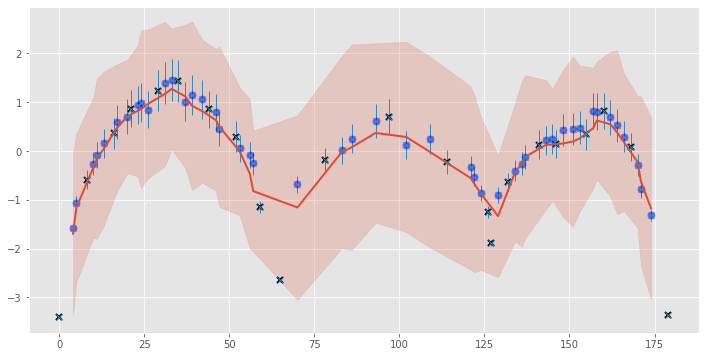

In [12]:

mu, var = model.predict_f(id_test)

plt.figure(figsize=(12, 6))
plt.plot(ang[id_train[:,0].astype(int)].reshape(-1), Y_all[id_train[:,0].astype(int)], "kx", mew=2, label="GT train_data")
plt.plot(ang[id_test[:,0].astype(int)].reshape(-1), Y_all[id_test[:,0].astype(int)], "bo", mew=2, alpha=.4, label="GT test_data")
plt.plot(ang[id_test[:,0].astype(int)].reshape(-1), mean.numpy(), lw=2, label="Predicted mean")

plt.fill_between(
    ang[id_test[:,0].astype(int)],
    mu[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mu[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)
plt.errorbar(
    ang,
    Y,
    yerr=2 * (np.sqrt(NoiseVar)).squeeze(),
    marker="x",
    lw=0,
    elinewidth=1.0,
    color="C1",
)
# _ = plt.xlim(-5, 5)

In [13]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_all[id_test[:,0].astype(int)], mean.numpy())

0.042846574870947826

In [14]:
import math
rmse = math.sqrt(mean_squared_error(Y_all[id_test[:,0].astype(int)], mean.numpy()))
rmse

0.2069941421174711

In [15]:
print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.2846550485482102
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.22841769665324252
VGP.q_mu,Parameter,Identity,,False,"(22, 1)",float64,[[-3.00819748...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 22, 22)",float64,"[[[5.08439365e-03, 0.00000000e+00, 0.00000000e+00..."


In [16]:
NoiseVar.max()

0.04650446517606763